# cache_ext plotting

## Setup

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bench_lib
import bench_plot_lib as plot_lib

importlib.reload(bench_lib)
importlib.reload(plot_lib)

GiB = 2**30

SYS_NAME = "cache_ext"
RESULTS_DIR = "../results/"
FIGURES_DIR = "../figures/"
POLICY_DIR = "../policies/"

In [4]:
# Create FIGURES_DIR
os.makedirs(FIGURES_DIR, exist_ok=True)

In [5]:
def iops_select_fn(r):
    return r["jobs"][0]["read"]["iops"]


def leveldb_throughput_avg_select_fn(r):
    return r["throughput_avg"]


def leveldb_read_throughput_avg_select_fn(r):
    return r["read_throughput_avg"]


def leveldb_scan_throughput_avg_select_fn(r):
    return r["scan_throughput_avg"]


def leveldb_latency_p99_select_fn(r):
    return (
        r["latency_p99"] / 10**6
        if r["latency_p99"] != 0
        else r["scan_latency_p99"] / 10**6
    )


def leveldb_read_latency_p99_select_fn(r):
    return r["read_latency_p99"] / 10**6


def leveldb_scan_latency_p99_select_fn(r):
    return r["scan_latency_p99"] / 10**6


def filter_cgroup_results(results, cgroup_name):
    return [r for r in results if r.config["cgroup_name"] == cgroup_name]


def filter_cache_ext_results(results):
    return filter_cgroup_results(results, bench_lib.DEFAULT_CACHE_EXT_CGROUP)


def add_config_field(results, key, value):
    for r in results:
        if key not in r.config:
            r.config[key] = value

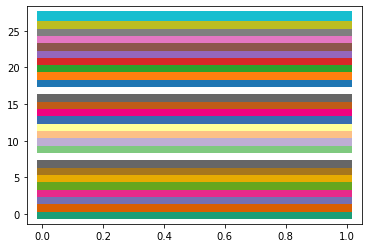

In [6]:
dark_colors = plt.colormaps["Dark2"].colors
accent_colors = plt.colormaps["Accent"].colors
tab10_colors = plt.colormaps["tab10"].colors

white=((1, 1, 1), )

colors = dark_colors + white + accent_colors + white + tab10_colors

for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, linewidth=10)

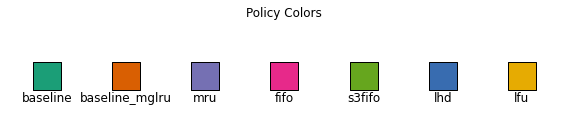

In [7]:
policy_color = {
    "baseline": dark_colors[0],
    "baseline_mglru": dark_colors[1],
    "mru": dark_colors[2],
    "fifo": dark_colors[3],
    "s3fifo": dark_colors[4],
    "lhd": accent_colors[4],
    "lfu": dark_colors[5],
}

plt.figure(figsize=(8, 2))
n = len(policy_color)
for i, (policy, color) in enumerate(policy_color.items()):
    plt.scatter(i, 0, color=color, s=800, marker='s', edgecolors='k')
    plt.text(i, -0.3, policy, ha='center', va='top', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title("Policy Colors")
plt.xlim(-0.5, n - 0.5)
plt.ylim(-1, 1)
plt.box(False)
plt.tight_layout()
plt.show()

## Twitter Traces (Figure 7)

In [ ]:
# Twitter results

clusters = [17, 18, 24, 34, 52]
results = []
mglru_results = []
for cluster in clusters:
    results += bench_lib.parse_results_file(
        RESULTS_DIR + "twitter_traces_%d_results.json" % cluster,
        bench_lib.BenchResults,
    )
    mglru_results += bench_lib.parse_results_file(
        RESULTS_DIR + "twitter_traces_%d_results_mglru.json" % cluster,
        bench_lib.BenchResults,
    )

cache_ext_results = filter_cache_ext_results(results)
baseline_results = filter_cgroup_results(results, bench_lib.DEFAULT_BASELINE_CGROUP)

add_config_field(cache_ext_results, "mglru", False)
add_config_field(baseline_results, "mglru", False)
add_config_field(mglru_results, "mglru", True)

config_matches = [
    {
        "name": "leveldb_twitter_trace_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size_pct", [10], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)

baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)

cache_ext_matches = bench_lib.add_config_option(
    "policy_loader",
    [
        "cache_ext_lhd.out",
        "cache_ext_s3fifo.out",
        "cache_ext_sampling.out",
    ],
    cache_ext_matches,
)

# new_config_matches = []
# for config in config_matches:
#     if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
#         new_config = config.copy()
#         new_config_matches.append(new_config)
#     else:
#         # for policy_loader in ["cache_ext_s3fifo.out"]:
#         for policy_loader in ["cache_ext_s3fifo.out", "cache_ext_sampling.out", "cache_ext_lhd.out"]:
#             new_config = config.copy()
#             new_config["policy_loader"] = policy_loader
#             new_config_matches.append(new_config)
# config_matches = new_config_matches


bench_types = ["twitter_cluster%d_bench" % cluster for cluster in clusters]
bench_type_to_group = {
    "twitter_cluster%d_bench" % cluster: "Cluster %d" % cluster for cluster in clusters
}

s3fifo_matches = [cm for cm in cache_ext_matches if "s3fifo" in cm["policy_loader"]]
lhd_matches = [cm for cm in cache_ext_matches if "lhd" in cm["policy_loader"]]
sampling_matches = [cm for cm in cache_ext_matches if "sampling" in cm["policy_loader"]]

config_matches = baseline_matches + s3fifo_matches + lhd_matches + sampling_matches


def name_func(config):
    if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
        if config["mglru"]:
            return "MGLRU (Linux)"
        else:
            return "Default (Linux)"
        # return "Baseline (%d%% cache)" % config["cgroup_size_pct"]
    elif "s3fifo" in config["policy_loader"].lower():
        return "S3-FIFO (%s)" % SYS_NAME
    elif "sampling" in config["policy_loader"].lower():
        return "LFU (%s)" % SYS_NAME
    elif "lhd" in config["policy_loader"].lower():
        return "LHD (%s)" % SYS_NAME


twitter_policies = ["baseline", "baseline_mglru", "s3fifo", "lhd", "lfu"]
twitter_colors = [policy_color[tp] for tp in twitter_policies]

plot_lib.bench_plot_groupped_results(
    config_matches,
    results + mglru_results,
    colors=twitter_colors,
    bench_types=bench_types,
    bench_type_to_group=bench_type_to_group,
    filename=FIGURES_DIR + "leveldb_twitter_traces_throughput.pdf",
    bar_width=0.5,
    show_measurements=True,
    y_label="Throughput (ops/sec)",
    name_func=name_func,
    result_select_fn=leveldb_throughput_avg_select_fn,
    normalize_per_group=False,
    legend_loc="best",
    label_fontsize=20,
    fontsize=12,
    measurement_fontsize=10,
    measurement_offset=2000,
    ylimit=130000,
)

{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster17_bench'}
[84199.16, 84541.94, 84160.75]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster18_bench'}
[80767.09, 77341.95, 79763.0]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster24_bench'}
[61922.71, 61900.07, 61950.32]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster34_bench'}
[15689.06, 15837.53, 15708.39]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster52_bench'}
[39044.51, 38797.87, 39037.43]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgr

<Figure size 640x480 with 0 Axes>

## Filesearch Benchmark (Figure 9)

In [10]:
def make_name(config) -> str:
    DEFAULT_CACHE_EXT_CGROUP = "cache_ext_test"
    DEFAULT_BASELINE_CGROUP = "baseline_test"
    if config["cgroup_name"] == DEFAULT_BASELINE_CGROUP:
        mglru = config.get("mglru", False)
        if mglru:
            return "MGLRU (Linux)"
        return "Default (Linux)"
    elif config["cgroup_name"] == DEFAULT_CACHE_EXT_CGROUP:
        return "MRU (%s)" % SYS_NAME
    return "<unknown>"


filesearch_results = bench_lib.parse_results_file(
    RESULTS_DIR + "filesearch_results.json", bench_lib.BenchResults
)

mglru_filesearch_results = bench_lib.parse_results_file(
    RESULTS_DIR + "filesearch_results_mglru.json", bench_lib.BenchResults
)

cache_ext_filesearch_results = filter_cache_ext_results(filesearch_results)
baseline_filesearch_results = filter_cgroup_results(
    filesearch_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

add_config_field(baseline_filesearch_results, "mglru", False)
add_config_field(cache_ext_filesearch_results, "mglru", False)
add_config_field(mglru_filesearch_results, "mglru", True)

filesearch_results = (
    baseline_filesearch_results
    + cache_ext_filesearch_results
    + mglru_filesearch_results
)

config_matches = [{"name": "filesearch_benchmark"}]
config_matches = bench_lib.add_config_option("cgroup_size", [1 * GiB], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)
# Add mglru option for baseline only
# Add mglru option for baseline only
baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
config_matches = baseline_matches + cache_ext_matches


def runtime_select_fn(r):
    return r["runtime_sec"]


colors = plt.colormaps["Dark2"].colors

plot_lib.bench_plot_groupped_results(
    config_matches,
    filesearch_results,
    y_label="Runtime (s)",
    show_measurements=False,
    colors=colors[0:3],  # ["salmon", "maroon", "limegreen"],
    bench_types=["filesearch"],
    result_select_fn=runtime_select_fn,
    bench_type_to_group={"filesearch": "File Search"},
    filename=FIGURES_DIR + "filesearch_results.pdf",
    label_fontsize=20,
    fontsize=20,
    legend_fontsize=16,
    ylimit=50,
    name_func=make_name,
)

{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'filesearch'}
[49.9923369884491]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': True, 'benchmark': 'filesearch'}
[51.02876091003418]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'cache_ext_test', 'benchmark': 'filesearch'}
[25.23619842529297]
[[49.9923369884491], [51.02876091003418], [25.23619842529297]]
[-1.  0.  1.]
[-1.]
[0.]
[1.]


<Figure size 640x480 with 0 Axes>

## YCSB Benchmark (Figure 6)

In [8]:
# YCSB results

def make_name(config) -> str:
    DEFAULT_CACHE_EXT_CGROUP = "cache_ext_test"
    DEFAULT_BASELINE_CGROUP = "baseline_test"
    if config["cgroup_name"] == DEFAULT_BASELINE_CGROUP:
        mglru = config.get("mglru", False)
        if mglru:
            return "MGLRU (Linux)"
        return "Default (Linux)"
    elif config["cgroup_name"] == DEFAULT_CACHE_EXT_CGROUP:
        if "s3fifo" in config["policy_loader"]:
            return "S3-FIFO (%s)" % SYS_NAME
        elif "sampling" in config["policy_loader"]:
            return "LFU (%s)" % SYS_NAME
        elif "lhd" in config["policy_loader"]:
            return "LHD (%s)" % SYS_NAME
        elif "fifo" in config["policy_loader"]:
            return "FIFO (%s)" % SYS_NAME
        elif "mru" in config["policy_loader"]:
            return "MRU (%s)" % SYS_NAME
    return "<unknown>"


ycsb_results = bench_lib.parse_results_file(
    RESULTS_DIR + "ycsb_results.json", bench_lib.BenchResults
)

mglru_ycsb_results = bench_lib.parse_results_file(
    RESULTS_DIR + "ycsb_results_mglru.json", bench_lib.BenchResults
)
cache_ext_ycsb_results = filter_cache_ext_results(ycsb_results)
baseline_ycsb_results = filter_cgroup_results(
    ycsb_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

add_config_field(baseline_ycsb_results, "mglru", False)
add_config_field(mglru_ycsb_results, "mglru", True)
add_config_field(cache_ext_ycsb_results, "mglru", False)

ycsb_results = baseline_ycsb_results + cache_ext_ycsb_results + mglru_ycsb_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]
config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)

print(config_matches)

baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
cache_ext_matches = bench_lib.add_config_option(
    "policy_loader",
    [
        "cache_ext_lhd.out",
        "cache_ext_s3fifo.out",
        "cache_ext_sampling.out",
        "cache_ext_fifo.out",
        "cache_ext_mru.out",
    ],
    cache_ext_matches,
)


print(cache_ext_matches)

mru_matches = [cm for cm in cache_ext_matches if "mru" in cm["policy_loader"]]
fifo_matches = [cm for cm in cache_ext_matches if "_fifo" in cm["policy_loader"]]
s3fifo_matches = [cm for cm in cache_ext_matches if "s3fifo" in cm["policy_loader"]]
lhd_matches = [cm for cm in cache_ext_matches if "lhd" in cm["policy_loader"]]
sampling_matches = [cm for cm in cache_ext_matches if "sampling" in cm["policy_loader"]]

matches = (
    baseline_matches
    + mru_matches
    + fifo_matches
    + s3fifo_matches
    + lhd_matches
    + sampling_matches
)

# Make a colors list for the policies
ycsb_colors = [ c for p, c in policy_color.items() ]

[{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test'}]
[{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_lhd.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_s3fifo.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_sampling.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_fifo.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_mru.out'}]


In [9]:
# Plot YCSB results 

plot_lib.leveldb_plot_ycsb_results(
    matches,
    ycsb_results,
    name_func=make_name,
    colors=ycsb_colors,  # "salmon", "maroon", "limegreen", "goldenrod"],
    bench_types=[
        "ycsb_a",
        "ycsb_b",
        "ycsb_c",
        "ycsb_d",
        "ycsb_e",
        "ycsb_f",
        "uniform",
        "uniform_read_write",
    ],
    # ["uniform", "uniform_read_write"],
    filename=FIGURES_DIR + "leveldb_ycsb_throughput.pdf",
    bar_width=0.5,
    show_measurements=True,
    result_select_fn=leveldb_throughput_avg_select_fn,
    ylimit=30000,
    text_center_list=[3],
    measurement_offset=300,
    measurement_fontsize=6.5,
    legend_fontsize=8,
    fontsize=11,
    label_fontsize=18,
)

plot_lib.leveldb_plot_ycsb_results(
    matches,
    ycsb_results,
    colors=ycsb_colors,
    name_func=make_name,
    bench_types=[
        "ycsb_a",
        "ycsb_b",
        "ycsb_c",
        "ycsb_d",
        "ycsb_e",
        "ycsb_f",
        "uniform",
        "uniform_read_write",
    ],
    filename=FIGURES_DIR + "leveldb_ycsb_latency.pdf",
    bar_width=0.5,
    legend_fontsize=8,
    result_select_fn=leveldb_latency_p99_select_fn,
    show_measurements=False,
    y_label="P99 Latency (ms)",
    fontsize=11,
    label_fontsize=18,
)

{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_a'}
[16830.93, 16991.14, 16921.68]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_b'}
[12832.36, 12635.26, 12917.67]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_c'}
[10644.44, 9783.8, 10711.2]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_d'}
[209459.05, 209486.47, 209640.27]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_e'}
[3067.99, 2734.55, 2599.87]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_f'}
[15975.45, 15974.48, 16613.16]
{'name': 'leveldb_benchmark', 'cgroup_size'

<Figure size 432x288 with 0 Axes>

In [19]:
# Disk Usage Analysis for YCSB workloads

def get_combined_disk_usage(result):
    """Extract combined disk usage for sda4 and sdb from a result"""
    disk_io = result.results.get("disk_io_usage", {}) if hasattr(result.results, 'get') else result.results["disk_io_usage"]
    
    sda4_data = disk_io.get("sda4", {}) if "sda4" in disk_io else {}
    sdb_data = disk_io.get("sdb", {}) if "sdb" in disk_io else {}
    
    # Combine read and write counts and bytes from both devices
    total_read_count = sda4_data.get("read_count", 0) + sdb_data.get("read_count", 0)
    total_write_count = sda4_data.get("write_count", 0) + sdb_data.get("write_count", 0)
    total_read_bytes = sda4_data.get("read_bytes", 0) + sdb_data.get("read_bytes", 0)
    total_write_bytes = sda4_data.get("write_bytes", 0) + sdb_data.get("write_bytes", 0)
    total_bytes = total_read_bytes + total_write_bytes
    
    return {
        "read_count": total_read_count,
        "write_count": total_write_count,
        "read_bytes": total_read_bytes,
        "write_bytes": total_write_bytes,
        "total_bytes": total_bytes,
        "read_gb": total_read_bytes / (1024**3),
        "write_gb": total_write_bytes / (1024**3),
        "total_gb": total_bytes / (1024**3)
    }

def extract_policy_name(config):
    """Extract policy name from config"""
    if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
        if config.get("mglru", False):
            return "MGLRU"
        return "Default"
    elif "s3fifo" in config.get("policy_loader", ""):
        return "S3-FIFO"
    elif "sampling" in config.get("policy_loader", ""):
        return "LFU"
    elif "lhd" in config.get("policy_loader", ""):
        return "LHD"
    elif "fifo" in config.get("policy_loader", ""):
        return "FIFO"
    elif "mru" in config.get("policy_loader", ""):
        return "MRU"
    return "Unknown"

def extract_workload_name(config):
    """Extract workload name from config"""
    benchmark = config.get("benchmark", "")
    # Keep the original case - don't convert to uppercase
    return benchmark

# Create disk usage table
workloads = ["ycsb_a", "ycsb_b", "ycsb_c", "ycsb_d", "ycsb_e", "ycsb_f", "uniform", "uniform_read_write"]
policies = ["Default", "MGLRU", "MRU", "FIFO", "S3-FIFO", "LHD", "LFU"]

# Initialize data structure
disk_usage_data = {}
for workload in workloads:
    disk_usage_data[workload] = {}
    for policy in policies:
        disk_usage_data[workload][policy] = {
            "read_count": 0, "write_count": 0, 
            "read_gb": 0, "write_gb": 0, "total_gb": 0, 
            "throughput_avg": 0, "count": 0
        }

# Process all YCSB results
for result in ycsb_results:
    config = result.config
    workload = extract_workload_name(config)
    policy = extract_policy_name(config)
    
    if workload in workloads and policy in policies:
        usage = get_combined_disk_usage(result)
        throughput = leveldb_throughput_avg_select_fn(result.results)
        
        disk_usage_data[workload][policy]["read_count"] += usage["read_count"]
        disk_usage_data[workload][policy]["write_count"] += usage["write_count"]
        disk_usage_data[workload][policy]["read_gb"] += usage["read_gb"]
        disk_usage_data[workload][policy]["write_gb"] += usage["write_gb"]
        disk_usage_data[workload][policy]["total_gb"] += usage["total_gb"]
        disk_usage_data[workload][policy]["throughput_avg"] += throughput
        disk_usage_data[workload][policy]["count"] += 1

# Calculate averages
for workload in workloads:
    for policy in policies:
        if disk_usage_data[workload][policy]["count"] > 0:
            count = disk_usage_data[workload][policy]["count"]
            disk_usage_data[workload][policy]["read_count"] /= count
            disk_usage_data[workload][policy]["write_count"] /= count
            disk_usage_data[workload][policy]["read_gb"] /= count
            disk_usage_data[workload][policy]["write_gb"] /= count
            disk_usage_data[workload][policy]["total_gb"] /= count
            disk_usage_data[workload][policy]["throughput_avg"] /= count

print("Disk Usage Analysis Complete")
print(f"Processed data for {len(workloads)} workloads and {len(policies)} policies")

Disk Usage Analysis Complete
Processed data for 8 workloads and 7 policies


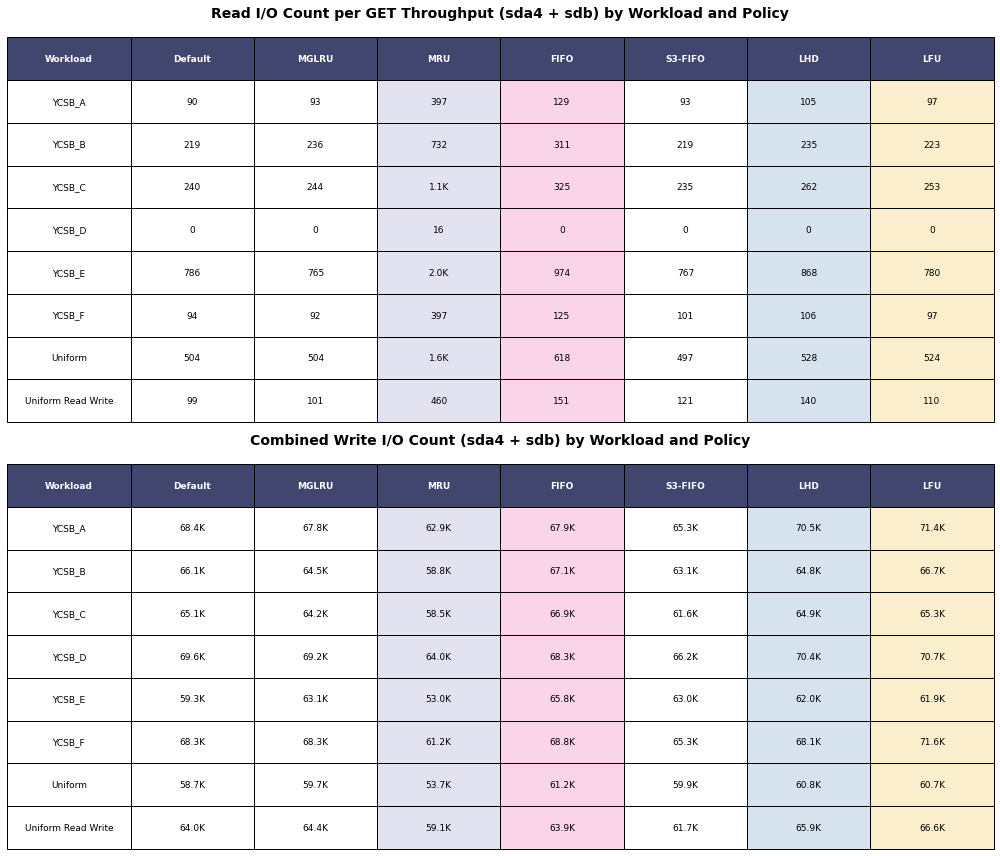

Read I/O Count per GET Throughput (sda4 + sdb):
          Workload Default MGLRU  MRU FIFO S3-FIFO LHD LFU
            YCSB_A      90    93  397  129      93 105  97
            YCSB_B     219   236  732  311     219 235 223
            YCSB_C     240   244 1.1K  325     235 262 253
            YCSB_D       0     0   16    0       0   0   0
            YCSB_E     786   765 2.0K  974     767 868 780
            YCSB_F      94    92  397  125     101 106  97
           Uniform     504   504 1.6K  618     497 528 524
Uniform Read Write      99   101  460  151     121 140 110

Combined Write I/O Count (sda4 + sdb):
          Workload Default MGLRU   MRU  FIFO S3-FIFO   LHD   LFU
            YCSB_A   68.4K 67.8K 62.9K 67.9K   65.3K 70.5K 71.4K
            YCSB_B   66.1K 64.5K 58.8K 67.1K   63.1K 64.8K 66.7K
            YCSB_C   65.1K 64.2K 58.5K 66.9K   61.6K 64.9K 65.3K
            YCSB_D   69.6K 69.2K 64.0K 68.3K   66.2K 70.4K 70.7K
            YCSB_E   59.3K 63.1K 53.0K 65.8K   63.0K 62.

In [20]:
# Create and display disk I/O count tables

# Helper function to format numbers with K/M suffixes
def format_number(num):
    """Format numbers with K/M suffixes, treating 0 as a valid value"""
    if num >= 1000000:
        return f"{num/1000000:.1f}M"
    elif num >= 1000:
        return f"{num/1000:.1f}K"
    else:
        return f"{int(num)}"

# Create READ COUNT / GET THROUGHPUT table
read_count_data = []
header = ["Workload"] + policies

for workload in workloads:
    workload_display = workload.upper() if workload.startswith("ycsb_") else workload.replace("_", " ").title()
    row = [workload_display]
    for policy in policies:
        read_count = disk_usage_data[workload][policy]["read_count"]
        throughput = disk_usage_data[workload][policy]["throughput_avg"]
        
        # Only show N/A if we have no data for this combination
        if disk_usage_data[workload][policy]["count"] == 0:
            row.append("N/A")
        elif throughput == 0:
            row.append("∞")  # Division by zero case
        else:
            # Calculate read count per unit of throughput
            ratio = read_count / throughput
            row.append(format_number(ratio))
    read_count_data.append(row)

# Create the READ COUNT table visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# READ COUNT TABLE
ax1.axis('tight')
ax1.axis('off')

read_table = ax1.table(
    cellText=read_count_data,
    colLabels=header,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

# Style the read count table
read_table.auto_set_font_size(False)
read_table.set_fontsize(9)
read_table.scale(1, 2)

# Color the header
for i in range(len(header)):
    read_table[(0, i)].set_facecolor('#40466e')
    read_table[(0, i)].set_text_props(weight='bold', color='white')

# Color policy columns with their respective colors (lighter version)
for i, policy in enumerate(policies):
    col_idx = i + 1  # +1 because first column is workload
    if policy.lower() in policy_color:
        color = policy_color[policy.lower()]
        # Make color lighter for table cells
        light_color = tuple(c + (1-c)*0.8 for c in color[:3])
        for row_idx in range(1, len(read_count_data) + 1):
            read_table[(row_idx, col_idx)].set_facecolor(light_color)

ax1.set_title("Read I/O Count per GET Throughput (sda4 + sdb) by Workload and Policy", 
             fontsize=14, fontweight='bold', pad=20)

# Create WRITE COUNT table
write_count_data = []
for workload in workloads:
    workload_display = workload.upper() if workload.startswith("ycsb_") else workload.replace("_", " ").title()
    row = [workload_display]
    for policy in policies:
        write_count = disk_usage_data[workload][policy]["write_count"]
        # Only show N/A if we have no data for this combination, not if the count is 0
        if disk_usage_data[workload][policy]["count"] == 0:
            row.append("N/A")
        else:
            row.append(format_number(write_count))
    write_count_data.append(row)

# WRITE COUNT TABLE
ax2.axis('tight')
ax2.axis('off')

write_table = ax2.table(
    cellText=write_count_data,
    colLabels=header,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

# Style the write count table
write_table.auto_set_font_size(False)
write_table.set_fontsize(9)
write_table.scale(1, 2)

# Color the header
for i in range(len(header)):
    write_table[(0, i)].set_facecolor('#40466e')
    write_table[(0, i)].set_text_props(weight='bold', color='white')

# Color policy columns with their respective colors (lighter version)
for i, policy in enumerate(policies):
    col_idx = i + 1  # +1 because first column is workload
    if policy.lower() in policy_color:
        color = policy_color[policy.lower()]
        # Make color lighter for table cells
        light_color = tuple(c + (1-c)*0.8 for c in color[:3])
        for row_idx in range(1, len(write_count_data) + 1):
            write_table[(row_idx, col_idx)].set_facecolor(light_color)

ax2.set_title("Combined Write I/O Count (sda4 + sdb) by Workload and Policy", 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIGURES_DIR + "ycsb_disk_io_count_per_throughput_tables.pdf", bbox_inches='tight')
plt.show()

# Create DataFrames for easier analysis
df_read_count = pd.DataFrame(read_count_data, columns=header)
df_write_count = pd.DataFrame(write_count_data, columns=header)

print("Read I/O Count per GET Throughput (sda4 + sdb):")
print(df_read_count.to_string(index=False))
print("\n" + "="*80)
print("Combined Write I/O Count (sda4 + sdb):")
print(df_write_count.to_string(index=False))

# Create numeric versions for LaTeX (without formatting)
read_count_numeric = []
write_count_numeric = []

for workload in workloads:
    workload_display = workload.upper() if workload.startswith("ycsb_") else workload.replace("_", " ").title()
    
    read_row = [workload_display]
    write_row = [workload_display]
    
    for policy in policies:
        read_count = disk_usage_data[workload][policy]["read_count"]
        write_count = disk_usage_data[workload][policy]["write_count"]
        throughput = disk_usage_data[workload][policy]["throughput_avg"]
        
        # For read count, calculate ratio to throughput
        if throughput > 0:
            read_ratio = read_count / throughput
            read_row.append(f"{read_ratio:.2f}")
        else:
            read_row.append("0")
            
        write_row.append(f"{int(write_count)}" if write_count > 0 else "0")
    
    read_count_numeric.append(read_row)
    write_count_numeric.append(write_row)

df_read_numeric = pd.DataFrame(read_count_numeric, columns=header)
df_write_numeric = pd.DataFrame(write_count_numeric, columns=header)

# Save tables to LaTeX
df_read_numeric.to_latex(
    FIGURES_DIR + "ycsb_disk_read_count.tex",
    index=False,
    caption="Read I/O count per GET throughput (sda4 + sdb) for each YCSB workload and caching policy.",
    label="tab:ycsb-disk-read-count",
    escape=False
)

df_write_numeric.to_latex(
    FIGURES_DIR + "ycsb_disk_write_count.tex",
    index=False,
    caption="Combined write I/O count (sda4 + sdb) for each YCSB workload and caching policy.",
    label="tab:ycsb-disk-write-count",
    escape=False
)

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Calculate some summary statistics
for workload in ["uniform", "uniform_read_write"]:
    if workload in disk_usage_data:
        print(f"\n{workload.upper()}:")
        print("Read counts by policy:")
        for policy in policies:
            read_count = disk_usage_data[workload][policy]["read_count"]
            if read_count > 0:
                print(f"  {policy}: {format_number(read_count)}")
        
        print("Write counts by policy:")
        for policy in policies:
            write_count = disk_usage_data[workload][policy]["write_count"]
            if write_count > 0:
                print(f"  {policy}: {format_number(write_count)}")

In [15]:
# Debug: Let's investigate why YCSB A-F workloads show N/A

print("DEBUGGING DISK USAGE DATA")
print("="*50)

# Check what workloads and policies we actually have data for
workloads_with_data = set()
policies_with_data = set()

for result in ycsb_results:
    config = result.config
    workload = extract_workload_name(config)
    policy = extract_policy_name(config)
    
    # Check if this result has disk_io_usage data
    try:
        disk_io = result.results.get("disk_io_usage", {}) if hasattr(result.results, 'get') else result.results["disk_io_usage"]
        if disk_io and ("sda4" in disk_io or "sdb" in disk_io):
            sda4_data = disk_io.get("sda4", {})
            sdb_data = disk_io.get("sdb", {})
            
            total_read_count = sda4_data.get("read_count", 0) + sdb_data.get("read_count", 0)
            total_write_count = sda4_data.get("write_count", 0) + sdb_data.get("write_count", 0)
            
            if total_read_count > 0 or total_write_count > 0:
                workloads_with_data.add(workload)
                policies_with_data.add(policy)
                print(f"Found data: {workload} + {policy} -> read: {total_read_count}, write: {total_write_count}")
    except Exception as e:
        print(f"Error processing {workload} + {policy}: {e}")

print(f"\nWorkloads with disk data: {sorted(workloads_with_data)}")
print(f"Policies with disk data: {sorted(policies_with_data)}")

# Check a few specific YCSB results
print(f"\nChecking specific YCSB results:")
for result in ycsb_results[:10]:  # Check first 10 results
    config = result.config
    workload = extract_workload_name(config)
    policy = extract_policy_name(config)
    
    if workload.startswith("YCSB_"):
        try:
            disk_io = result.results.get("disk_io_usage", {}) if hasattr(result.results, 'get') else result.results["disk_io_usage"]
            print(f"{workload} + {policy}: has disk_io_usage = {disk_io is not None and len(disk_io) > 0}")
            if disk_io:
                print(f"  Available devices: {list(disk_io.keys())}")
        except Exception as e:
            print(f"  Error: {e}")

# Let's also check the actual count values in our processed data
print(f"\nProcessed data summary:")
for workload in workloads:
    has_data = False
    for policy in policies:
        if disk_usage_data[workload][policy]["count"] > 0:
            has_data = True
            break
    print(f"{workload}: {'HAS DATA' if has_data else 'NO DATA'}")

# Check the format_number function behavior
print(f"\nTesting format_number function:")
test_values = [0, 1, 999, 1000, 1500, 1000000, 2500000]
for val in test_values:
    print(f"format_number({val}) = '{format_number(val)}'")

DEBUGGING DISK USAGE DATA
Found data: YCSB_A + Default -> read: 1533338, write: 68128
Found data: YCSB_A + Default -> read: 1539508, write: 68732
Found data: YCSB_A + Default -> read: 1538236, write: 68424
Found data: YCSB_B + Default -> read: 2824411, write: 65943
Found data: YCSB_B + Default -> read: 2798912, write: 66281
Found data: YCSB_B + Default -> read: 2816792, write: 66062
Found data: YCSB_C + Default -> read: 2549130, write: 65537
Found data: YCSB_C + Default -> read: 2390268, write: 64383
Found data: YCSB_C + Default -> read: 2562162, write: 65379
Found data: YCSB_D + Default -> read: 161304, write: 69498
Found data: YCSB_D + Default -> read: 162601, write: 69830
Found data: YCSB_D + Default -> read: 162704, write: 69586
Found data: YCSB_E + Default -> read: 2378370, write: 64342
Found data: YCSB_E + Default -> read: 2160884, write: 56797
Found data: YCSB_E + Default -> read: 2072617, write: 56689
Found data: YCSB_F + Default -> read: 1521055, write: 68287
Found data: YCSB_

In [16]:
# Focused debug: Check the format_number function issue

print("CHECKING FORMAT_NUMBER ISSUE")
print("="*40)

# The issue is likely that format_number returns "N/A" for 0 values
# But we might have actual 0 counts vs missing data

# Let's check our actual data structure
print("Sample of actual disk_usage_data:")
for workload in ["YCSB_A", "uniform"]:
    if workload in disk_usage_data:
        print(f"\n{workload}:")
        for policy in ["Default", "MRU"]:
            if policy in disk_usage_data[workload]:
                data = disk_usage_data[workload][policy]
                print(f"  {policy}: read_count={data['read_count']}, write_count={data['write_count']}, count={data['count']}")

# Check if we have zero vs missing data
print(f"\nChecking zero vs missing data:")
for workload in workloads:
    for policy in policies:
        data = disk_usage_data[workload][policy]
        if data["count"] > 0:  # We have results for this combination
            if data["read_count"] == 0 and data["write_count"] == 0:
                print(f"{workload} + {policy}: Has results but zero I/O counts")
            elif data["read_count"] > 0 or data["write_count"] > 0:
                print(f"{workload} + {policy}: Has non-zero I/O counts")

# The issue is in the format_number function - it shows N/A for 0 values
# But 0 is actually meaningful data (no I/O operations)
print(f"\nTesting our current format_number vs a better one:")

def format_number_better(num):
    """Improved format function that distinguishes between 0 and missing data"""
    if num >= 1000000:
        return f"{num/1000000:.1f}M"
    elif num >= 1000:
        return f"{num/1000:.1f}K"
    else:
        return f"{int(num)}"

test_values = [0, 1, 999, 1000, 1500, 1000000, 2500000]
for val in test_values:
    print(f"Value {val}: current='{format_number(val)}', better='{format_number_better(val)}'")

CHECKING FORMAT_NUMBER ISSUE
Sample of actual disk_usage_data:

uniform:
  Default: read_count=2533937.6666666665, write_count=58681.666666666664, count=3
  MRU: read_count=4074653.6666666665, write_count=53723.333333333336, count=3

Checking zero vs missing data:
uniform + Default: Has non-zero I/O counts
uniform + MGLRU: Has non-zero I/O counts
uniform + MRU: Has non-zero I/O counts
uniform + FIFO: Has non-zero I/O counts
uniform + S3-FIFO: Has non-zero I/O counts
uniform + LHD: Has non-zero I/O counts
uniform + LFU: Has non-zero I/O counts
uniform_read_write + Default: Has non-zero I/O counts
uniform_read_write + MGLRU: Has non-zero I/O counts
uniform_read_write + MRU: Has non-zero I/O counts
uniform_read_write + FIFO: Has non-zero I/O counts
uniform_read_write + S3-FIFO: Has non-zero I/O counts
uniform_read_write + LHD: Has non-zero I/O counts
uniform_read_write + LFU: Has non-zero I/O counts

Testing our current format_number vs a better one:
Value 0: current='N/A', better='0'
Val

## GET-SCAN Benchmark (FIgure 8)

In [ ]:
# Mixed GET-SCAN results

get_scan_results = bench_lib.parse_results_file(
    RESULTS_DIR + "get_scan_results.json", bench_lib.BenchResults
)
mglru_get_scan_results = bench_lib.parse_results_file(
    RESULTS_DIR + "get_scan_results_mglru.json", bench_lib.BenchResults
)
cache_ext_get_scan_results = filter_cache_ext_results(get_scan_results)
baseline_get_scan_results = filter_cgroup_results(
    get_scan_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

add_config_field(baseline_get_scan_results, "mglru", False)
add_config_field(mglru_get_scan_results, "mglru", True)
add_config_field(cache_ext_get_scan_results, "mglru", False)
get_scan_results = (
    baseline_get_scan_results
    + cache_ext_get_scan_results
    + mglru_get_scan_results
)

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)

# Get the baseline config and generate two more:
# - One with "fadvise": "NOREUSE"
# - One with "fadvise": "DONTNEED"
# - One with "fadvise": "SEQUENTIAL"

baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]

baseline_matches = bench_lib.add_config_option("mglru", [False], baseline_matches)
baseline_matches = bench_lib.add_config_option(
    "fadvise", ["", "NOREUSE", "DONTNEED", "SEQUENTIAL"], baseline_matches
)
baseline_mglru_match = baseline_matches[0].copy()
baseline_mglru_match["mglru"] = True
baseline_matches.append(baseline_mglru_match)

config_matches = baseline_matches + cache_ext_matches


baseline_idx = 0
cache_ext_idx = -1

config_matches[baseline_idx]["iteration"] = 1
# throughput_baseline = leveldb_read_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# latency_baseline = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# throughput_cache_ext = leveldb_read_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
# latency_cache_ext = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Get averages from results
throughput_baseline = np.mean(
    [
        leveldb_read_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
latency_baseline = np.mean(
    [
        leveldb_read_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
throughput_cache_ext = np.mean(
    [
        leveldb_read_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)
latency_cache_ext = np.mean(
    [
        leveldb_read_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)

# Calculate improvement over baseline
throughput_improvement = throughput_cache_ext / throughput_baseline
latency_improvement = (latency_baseline - latency_cache_ext) / latency_baseline * 100
print(f"Throughput improvement: {throughput_improvement:.2f}x")
print(f"Latency reduction: {latency_improvement:.2f}%")
print(
    "Latency: baseline %.2fms, cache_ext %.2fms" % (latency_baseline, latency_cache_ext)
)

# scan_throughput_baseline = leveldb_scan_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# scan_latency_baseline = leveldb_scan_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# scan_throughput_cache_ext = leveldb_scan_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
# scan_latency_cache_ext = leveldb_scan_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Get averages from results
scan_throughput_baseline = np.mean(
    [
        leveldb_scan_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
scan_latency_baseline = np.mean(
    [
        leveldb_scan_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
scan_throughput_cache_ext = np.mean(
    [
        leveldb_scan_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)
scan_latency_cache_ext = np.mean(
    [
        leveldb_scan_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)

scan_throughput_improvement = scan_throughput_cache_ext / scan_throughput_baseline
scan_latency_improvement = (
    (scan_latency_baseline - scan_latency_cache_ext) / scan_latency_baseline * 100
)
print(f"Scan throughput improvement: {scan_throughput_improvement:.2f}x")
print(f"Scan latency reduction: {scan_latency_improvement:.2f}%")
print(
    "Scan latency: baseline %.2fms, cache_ext %.2fms"
    % (scan_latency_baseline, scan_latency_cache_ext)
)

colorsb = plt.colormaps["tab20b"].colors
colorsc = plt.colormaps["Dark2"].colors
colors = list(colorsb[:4]) + [colorsc[0]] + [colorsc[1]]
print(colors)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_throughput_avg_select_fn,
    colors=colors,
    # colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    measurement_fontsize=20,
    ylimit=8000,
    legend_fontsize=16,
    measurement_offset=300,
    legend_loc="upper left",
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_scan_throughput_avg_select_fn,
    colors=colors,
    # colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    measurement_fontsize=20,
    ylimit=80,
    legend_fontsize=16,
    measurement_offset=300,
    legend_loc="upper left",
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_latency_p99_select_fn,
    colors=colors,
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_latency.pdf",
    y_label="Latency (ms)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    legend_fontsize=16,
    legend_loc="best",
    ylimit=150,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_scan_latency_p99_select_fn,
    colors=colors,
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_scan_latency.pdf",
    y_label="Latency (ms)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    legend_fontsize=16,
    legend_loc="best",
    ylimit=1200,
)

Throughput improvement: 1.70x
Latency reduction: 57.12%
Latency: baseline 34.38ms, cache_ext 14.74ms
Scan throughput improvement: 0.82x
Scan latency reduction: -1.68%
Scan latency: baseline 66.05ms, cache_ext 67.16ms
[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686), (0.3215686274509804, 0.32941176470588235, 0.6392156862745098), (0.4196078431372549, 0.43137254901960786, 0.8117647058823529), (0.611764705882353, 0.6196078431372549, 0.8705882352941177), (0.10588235294117647, 0.6196078431372549, 0.4666666666666667), (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': '', 'iteration': 1, 'benchmark': 'mixed_get_scan'}
[1690.77]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': 'NOREUSE', 'benchmark': 'mixed_get_scan'}
[1717.09, 1699.05, 1689.56]
{'name': 'leveldb_benchmark', 'cgroup_si

<Figure size 432x288 with 0 Axes>

## Policy Lines of Code (Table 3)

Note that the Admission filter LoC are added manually, as they are not part of the policy files.


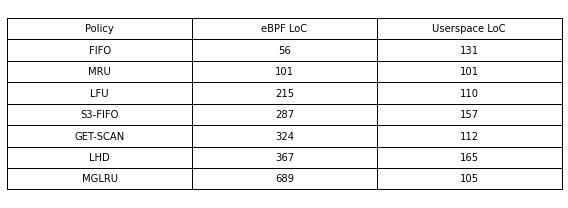

In [3]:
# Lines of code required for each policy

def c_file_is_loc(line: str):
    line = line.strip()
    if line.startswith("//") or line.startswith("/*") or line == "":
        return False
    return True


def c_file_count_loc(file_name: str):
    if not file_name.endswith(".c"):
        raise ValueError("File must be a C file")
    with open(POLICY_DIR + file_name, "r") as f:
        lines = f.readlines()
    loc_count = 0
    for line in lines:
        if c_file_is_loc(line):
            loc_count += 1
    return loc_count


mru_loc_count = c_file_count_loc("cache_ext_mru.bpf.c")
lfu_loc_count = c_file_count_loc("cache_ext_sampling.bpf.c")
get_scan_loc_count = c_file_count_loc("cache_ext_get_scan.bpf.c")
lhd_loc_count = c_file_count_loc("cache_ext_lhd.bpf.c")
s3fifo_loc_count = c_file_count_loc("cache_ext_s3fifo.bpf.c")
fifo_loc_count = c_file_count_loc("cache_ext_fifo.bpf.c")
mglru_loc_count = c_file_count_loc("cache_ext_mglru.bpf.c")

mru_user_loc_count = c_file_count_loc("cache_ext_mru.c")
lfu_user_loc_count = c_file_count_loc("cache_ext_sampling.c")
get_user_scan_loc_count = c_file_count_loc("cache_ext_get_scan.c")
lhd_user_loc_count = c_file_count_loc("cache_ext_lhd.c")
s3fifo_user_loc_count = c_file_count_loc("cache_ext_s3fifo.c")
fifo_user_loc_count = c_file_count_loc("cache_ext_fifo.c")
mglru_user_loc_count = c_file_count_loc("cache_ext_mglru.c")

# Put the LOC data in a table
table_data = [
    ["MRU", mru_loc_count, mru_user_loc_count],
    ["LFU", lfu_loc_count, lfu_user_loc_count],
    ["GET-SCAN", get_scan_loc_count, get_user_scan_loc_count],
    ["LHD", lhd_loc_count, lhd_user_loc_count],
    ["S3-FIFO", s3fifo_loc_count, s3fifo_user_loc_count],
    ["FIFO", fifo_loc_count, fifo_user_loc_count],
    ["MGLRU", mglru_loc_count, mglru_user_loc_count],
]

# Sort by LOC count
table_data.sort(key=lambda x: x[1])
# table_data_userspace.sort(key=lambda x: x[1])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(
    cellText=table_data,
    colLabels=["Policy", "eBPF LoC", "Userspace LoC"],
    cellLoc="center",
    loc="center",
)

print("Note that the Admission filter LoC are added manually, as they are not part of the policy files.")

table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Policy", "eBPF LoC", "Userspace LoC"])
df.to_latex(
    FIGURES_DIR + "loc_table.tex",
    index=False,
    caption="Lines of code required for each policy presented.",
    label="tab:loc-per-policy",
)

In [52]:
# Kernel lines of code

verifier = 1 + 3 + 86
core_cache_ext = 105 + 57 + 27 + 156 + 235
kfuncs = 748
page_cache = 26 + 8 + 175
cgroup = 80
per_cgroup = 5 + 3 + 1 + 6 + 200 + 3
libbpf = 73

print("Verifier: %d" % verifier)
print("Core Cache Ext: %d" % core_cache_ext)
print("Kfuncs: %d" % kfuncs)
print("Page Cache: %d" % page_cache)
print("Cgroup: %d" % cgroup)
print("Per Cgroup: %d" % per_cgroup)
print("Libbpf: %d" % libbpf)

total = verifier + core_cache_ext + kfuncs + page_cache + cgroup + per_cgroup + libbpf
print("Total: %d" % total)

Verifier: 90
Core Cache Ext: 580
Kfuncs: 748
Page Cache: 209
Cgroup: 80
Per Cgroup: 218
Libbpf: 73
Total: 1998


## FIO Microbenchmark (Table 4)

In [ ]:
# fio results

fio_results = bench_lib.parse_results_file(
    RESULTS_DIR + "cpu_overhead_results.json", bench_lib.BenchResults
)

cache_ext_fio_results = filter_cache_ext_results(fio_results)
baseline_fio_results = filter_cgroup_results(
    fio_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

cgroup_sizes = [5 * GiB, 10 * GiB, 30 * GiB]

def cpu_usage_per_iop_select_fn(r):
    return r["cpu_usage"] / iops_select_fn(r)

baseline_cpu_usage = {}
baseline_mglru_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
}

baseline_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_cpu = plot_lib.results_select(
        fio_results, baseline_config_match, cpu_usage_per_iop_select_fn
    )
    baseline_cpu_usage[cgroup_size] = np.mean(baseline_cpu) * 10**6

    cache_ext_config_match["cgroup_size"] = cgroup_size
    cache_ext_cpu = plot_lib.results_select(
        fio_results, cache_ext_config_match, cpu_usage_per_iop_select_fn
    )
    cache_ext_cpu_usage[cgroup_size] = np.mean(cache_ext_cpu) * 10**6

    cpu_usage_diff[cgroup_size] = (
        (cache_ext_cpu_usage[cgroup_size] - baseline_cpu_usage[cgroup_size])
        / cache_ext_cpu_usage[cgroup_size]
        * 100
    )

# Put the CPU overhead data in a table
table_data = []

# Add a row for CPU usage

table_data = [ 
    [
        f"{c / GiB} GiB",
        f"{baseline_cpu_usage[c]:.2f}",
        f"{cache_ext_cpu_usage[c]:.2f}",
        f"{cpu_usage_diff[c]:.2f}%"
    ]
    for c in cgroup_sizes
]

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(
    cellText=table_data,
    colLabels=["Cgroup Size", "Baseline", SYS_NAME, "Overhead (%)"],
    cellLoc="center",
    loc="center",
)
table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(
    table_data,
    columns=["Cgroup Size", "Baseline", SYS_NAME, "Overhead (%)"],
)
df.to_latex(
    FIGURES_DIR + "cpu_overhead_table.tex",
    index=False,
    caption="fio microbenchmark results to measure CPU overhead of \name per IO operation.",
    label="tab:eval-cpu-overhead",
)

## Per-Cgroup Benchmark (Figure 10)

[(5570.753333333334, 68.0), (7864.686666666667, 84.0), (2233.3333333333335, 116.0), (8343.94, 122.0)]
Split configuration throughput improvement over baseline: 49.78%
Split configuration RG iters improvement over baseline: 79.41%


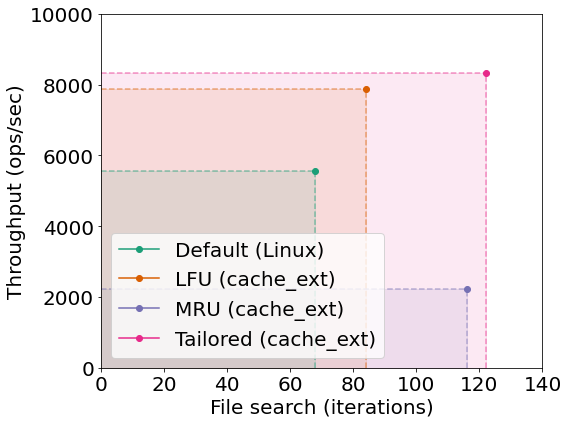

In [ ]:
baseline_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_baseline_results.json", bench_lib.BenchResults
)
both_lfu_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_both_lfu_results.json", bench_lib.BenchResults
)
both_mru_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_both_mru_results.json", bench_lib.BenchResults
)
split_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_split_results.json", bench_lib.BenchResults
)

print(baseline_results[0].results)


# Compute the average of the results["throughput_avg"] and results["rg_iters"] fields for each set of results
def avg_throughput_and_rg_iters(results):
    throughput_avg = np.mean([r.results["throughput_avg"] for r in results])
    rg_iters = np.mean([r.results["rg_iters"] for r in results])
    return throughput_avg, rg_iters


labels = [
    "Default (Linux)",
    "LFU (%s)" % SYS_NAME,
    "MRU (%s)" % SYS_NAME,
    "Tailored (%s)" % SYS_NAME,
]
results = [baseline_results, both_lfu_results, both_mru_results, split_results]
avg_throughputs_and_iters = [avg_throughput_and_rg_iters(r) for r in results]
print(avg_throughputs_and_iters)

colors = plt.colormaps["Dark2"].colors[:4]

# Create a point plot using matplotlib, with throughput on the y-axis and RG iters on the x-axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the throughput and RG iters for each set of results
for i in range(len(results)):
    # Use colors from colors list
    ax.plot(
        avg_throughputs_and_iters[i][1],
        avg_throughputs_and_iters[i][0],
        marker="o",
        color=colors[i],
        label=labels[i],
    )

# Add dotted lines to each of the points from the x axis and y axis using appropriate colors
# Trim the lines after each point
for i in range(len(results)):
    ax.plot(
        [0, avg_throughputs_and_iters[i][1]],
        [avg_throughputs_and_iters[i][0], avg_throughputs_and_iters[i][0]],
        linestyle="--",
        color=colors[i],
        alpha=0.5,
    )
    ax.plot(
        [avg_throughputs_and_iters[i][1], avg_throughputs_and_iters[i][1]],
        [0, avg_throughputs_and_iters[i][0]],
        linestyle="--",
        color=colors[i],
        alpha=0.5,
    )

# Fill in the rectangles created by the lines in reverse order
for i in range(len(results) - 1, -1, -1):
    ax.fill_between(
        [0, avg_throughputs_and_iters[i][1]],
        0,
        avg_throughputs_and_iters[i][0],
        color=colors[i],
        alpha=0.1,
    )

# Set x-axis and y-axis to start at 0
ax.set_xlim(left=0, right=140)
ax.set_ylim(bottom=0, top=10000)

# Set tick fontsize
ax.tick_params(axis="both", which="major", labelsize=20)

# Add labels
ax.set_xlabel("File search (iterations)", fontsize=20)
ax.set_ylabel("Throughput (ops/sec)", fontsize=20)

# Add a legend
ax.legend(loc="best", fontsize=20)

# Save to PDF
plt.tight_layout()
plt.savefig(FIGURES_DIR + "per_cgroup.pdf")

# Print percent improvement of split configuration over baseline
baseline_throughput = avg_throughputs_and_iters[0][0]
split_throughput = avg_throughputs_and_iters[3][0]
improvement = (split_throughput - baseline_throughput) / baseline_throughput * 100
print(f"Split configuration throughput improvement over baseline: {improvement:.2f}%")

baseline_iters = avg_throughputs_and_iters[0][1]
split_iters = avg_throughputs_and_iters[3][1]
improvement = (split_iters - baseline_iters) / baseline_iters * 100
print(f"Split configuration RG iters improvement over baseline: {improvement:.2f}%")

# add_config_field(baseline_results, "type", 1)
# add_config_field(both_lfu_results, "type", 2)
# add_config_field(both_mru_results, "type", 3)
# add_config_field(split_results, "type", 4)

# results = baseline_results + both_lfu_results + both_mru_results + split_results

## MGLRU Overhead (Table 5)